# SWMAL Exercise

## Learning Curves

### The Generalization Error, Over- and Underfitting, Early Stopping, and Optimal Capacity

In this exercise, we need to explain all important overall concepts in training. Let's begin with Figure 5.3 from Deep Learning (Ian Goodfellow, et. al. [DL]), which pretty much sums it all up

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/dl_generalization_error.png" alt="WARNING: could not get image from server." style="height:500px">

### Qa) The Generalization Error

Write a detailed description of figure 5.3 (above) for your hand-in.

All concepts in the figure must be explained

- training/generalization error,
- underfit/overfit zone,
- optimal capacity,
- generalization gab,
- and the two axes: x/capacity, y/error.


## Qa Answer

### Training and generalization error

When training a model, some loss function is often used to measure how good it is at doing its job. This can not just be used to measure how good it is at predicting new data, but also be used during training, to see the error it makes in the training data itself. So during training, before it trains on a certain data point, it checks its prediction for it first, and then measures the error from the actual value. This gives us the training error, which is a measurement of how well our model predict the training data. But just because it is good at that, does not mean it is good on test/actual data.

Generalization is found the same way, but just with the test data instead. This indicates how well our model can predict new data, from training on the training data.

### Underfit/overfit zone

Underfitting is when our model is not good enough to even predict its own training data. This is what happens early in the models training, when it hasn't run for very long. This can also happen if there is not enough data to train on, and the model is unable to become good enough.

Opposite the underfit zone, we have the overfit zone. This is when our model trains 'too well', meaning that it becomes so good at predicting the training data, that it fails on real data. here the training error will be extremely small, but the generalization error is much larger.

### Optimal capacity

Between the underfit/overfit zones, there is an optimal capacity, where the model is good at both predicting new training data, and test data with low errors. This is where you usually want to stop the training, since training it further probably will just push it into the overfitting zone.

### Generalization gap

The generalization gap is the difference between the error the model predicts on new training data vs test data. If there is a large difference, the model is probably overfitting. You want these to be close together, but not exactly the same. If they are, you have probably made a mistake somewhere, like using testdata to train on.

### Axes explained

The y-axis is the calculated error, for both the training and test data. The larger it is, the worse prediction the model is making.

The x-axis is the models capacity, which refers to the models ability to fit a variety of functions and patterns in the data. If the capacity is too small, it will be like trying to do a linear fit on very advanced and varying datasets. This will make it give quite bad predictions on test data.

If the capacity is too large, it will fit too well on training data. We can imagine that the training data is not very varied or advanced, and our model is so advanced and has such a high capacity, that given enough training, it just produces a line between each data point. Then it will be extremely good at predicting the training data, but awful at new test data.


### Qb Learning Curves

Next, produce a loss vs epoch graph ala (from `04_training_linear_models.ipynb` [GITHOML])

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/training_curve.png" alt="WARNING: could not get image from server.">

for your linear regressor, `MyLinReg`, from an earlier lesson. You need a function

> `LossHistory()`

on your regressor class, that accumulates the internally calculated $J$'s. Once `LossHistory` is ready, plot it using the code below.


In [65]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import add_dummy_feature
import numpy as np

class MyLinReg(BaseEstimator, RegressorMixin):
    def __init__(self: 'MyLinReg', eta0=0.01, max_iter=10000, tol=1e-4, n_iter_no_change=10, validation_split=0.0, verbose=True):
        self.eta0: float = eta0
        self.max_iter: int = max_iter
        self.tol: float = tol
        self.n_iter_no_change: int = n_iter_no_change
        self.validation_split: float = validation_split
        self.verbose: bool = verbose
        self.intercept_: float = 0.0 # dummy init value
        self.coef_: np.ndarray = np.array([0.0]) # dummy init value
        self.train_loss_history_ = [] 
        self.val_loss_history_ = []

    def _MSE(self: 'MyLinReg', y_pred: np.ndarray, y_true: np.ndarray) -> float:
        assert len(y_pred) == len(y_true) and y_pred.ndim == 1 and y_true.ndim == 1
        err_vec = y_pred - y_true # Xw - y
        return np.mean(err_vec ** 2)

    # loss function isnt used. But could be used in terms of early stopping.
    def _loss(self: 'MyLinReg', X, y) -> float:
        y_pred = self.predict(X)
        return self._MSE(y_pred, y)

    def __str__(self: 'MyLinReg') -> str: 
        return "MyLinReg.__str__(): hi!"

    def fit(self: 'MyLinReg', X: np.ndarray, y: np.ndarray) -> None:        
        self.train_loss_history_ = [] # reset history
        self.val_loss_history_ = []   # reset history

        X_train, y_train = X, y
        X_val, y_val = None, None # Init
        
        # Split data if validation_split is set
        if self.validation_split > 0.0 and self.validation_split < 1.0:
            X_train, X_val, y_train, y_val = train_test_split(
                X, y, test_size=self.validation_split, random_state=42
            )
        else:
            X_val, y_val = X_train, y_train

        # Run batch or stocastich
        self._batch(X_train, y_train, X_val, y_val)
        # self._sgd(X_train, y_train, X_val, y_val)
        return self

    def predict(self: 'MyLinReg', X: np.ndarray) -> np.ndarray:
        return X @ self.coef_ + self.intercept_
    
    def _batch(self: 'MyLinReg', X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        # Add bias term
        X_b = add_dummy_feature(X)
        X_val_b = add_dummy_feature(X_val)

        n_samples, n_features = X_b.shape
        np.random.seed(42)
        theta = np.random.randn(n_features, 1) # random initialization of parameters

        best_val_loss = np.inf # infinity
        no_improvement_count = 0

        for epoch in range(self.max_iter):
            # Compute predictions: X w
            y_pred_train = X_b @ theta

            # Compute gradient: (2/n) X_b^T (y_pred - y)
            gradient = (2.0 / n_samples) * X_b.T @ (y_pred_train - y.reshape(-1, 1))
            
            # Update theta
            theta -= self.eta0 * gradient

            # Calculate training loss
            train_loss = self._MSE(y_pred_train.ravel(), y.ravel())
            self.train_loss_history_.append(train_loss)
            
            # Calculate validation loss
            y_pred_val = X_val_b @ theta
            val_loss = self._MSE(y_pred_val.ravel(), y_val.ravel())
            self.val_loss_history_.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss - self.tol:
                best_val_loss = val_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            if no_improvement_count >= self.n_iter_no_change:
                if self.verbose:
                    print(f"Stopping early at epoch {epoch} (Batch GD). Validation loss stopped improving.")
                break

        # Store final parameters
        self.intercept_ = float(theta.ravel()[0])
        self.coef_ = theta[1:].ravel()
                
    # its kinda funny how "unpredictable" SGD is. You can really finetune with all the hyperparameters(and you have to)
    def _sgd(self: 'MyLinReg', X: np.ndarray, y: np.ndarray, X_val: np.ndarray, y_val: np.ndarray):
        # Add bias term
        X_b = add_dummy_feature(X)
        X_val_b = add_dummy_feature(X_val)

        n_samples, n_features = X_b.shape
        np.random.seed(42)
        theta = np.random.randn(n_features, 1) # random initialization of parameters

        best_val_loss = np.inf # infinity
        no_improvement_count = 0

        for epoch in range(self.max_iter):
            # Shuffle data, this means there is no "tilbagelægning" during an epoch
            indices = np.random.permutation(n_samples)
            # This part is almost identical to HOML, but without the learning schedule(variable eta)
            for i in indices:
                xi = X_b[i:i+1]
                yi = y[i:i+1]

                # Prediction
                y_pred_i = xi @ theta

                # Compute gradient: 2 X_b^T (y_pred - y)
                gradient = 2.0 * xi.T @ (y_pred_i - yi.reshape(-1, 1))

                # Update theta
                theta -= self.eta0 * gradient
            
            # Calculate training loss
            y_pred_train = X_b @ theta
            train_loss = self._MSE(y_pred_train.ravel(), y.ravel())
            self.train_loss_history_.append(train_loss)

            # Calculate validation loss
            y_pred_val = X_val_b @ theta 
            val_loss = self._MSE(y_pred_val.ravel(), y_val.ravel())
            self.val_loss_history_.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss - self.tol:
                best_val_loss = val_loss
                no_improvement_count = 0
            else:
                no_improvement_count += 1
            
            if no_improvement_count >= self.n_iter_no_change:
                if self.verbose:
                    print(f"Stopping early at epoch {epoch} (SGD). Validation loss stopped improving.")
                break

        # Store final parameters
        self.intercept_ = float(theta.ravel()[0])
        self.coef_ = theta[1:].ravel()

    def TrainLossHistory(self):
        return self.train_loss_history_

Stopping early at epoch 171 (Batch GD). Validation loss stopped improving.


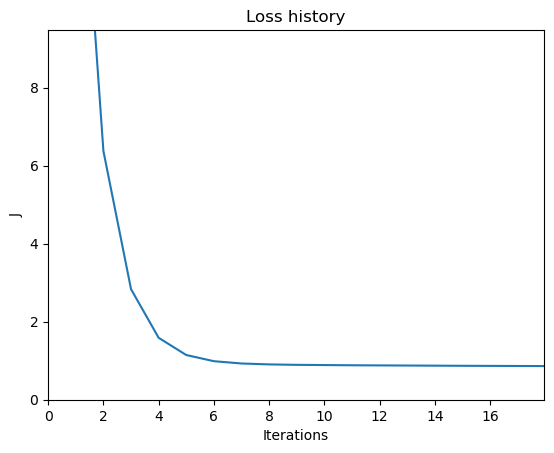

OK


In [66]:
import numpy as np

# Some dummy linear data
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

# Train your model
r = MyLinReg(eta0=0.1, max_iter=1000, tol=1e-6, verbose=True)
r.fit(X, y)

h = r.TrainLossHistory()

%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
plt.plot(h)

ax.set_title("Loss history")
ax.set_xlabel("Iterations")
ax.set_ylabel("J")

zoom_axis = True
if zoom_axis:
    limits_x = ax.get_xlim()
    limits_y = ax.get_ylim()
    ax.set_ylim([0, limits_y[1]/5]) # zoom on y axis
    ax.set_xlim([0, limits_x[1]/10]) # zoom on x axis
    
plt.show()

print("OK")

### Qc) Early Stopping

Then implement **_early stopping_**, in your `MyLinReg` estimator. Below is a graphical view of early stopping similar to Figure 4-20 p.162 [HOML] (for a non-linear model?)

<img src="https://itundervisning.ase.au.dk/SWMAL/L08/Figs/early_stopping.png" alt="WARNING: could not get image from server.">

Write an explanation of the early stopping concept in text, implement it in your linear regressor and write some test/demo code, that via some learning-curve graphs demonstrates how it works when training your linear regressor in both _batch-gradient descent_ and
_stochastic gradient descent_ modes.


### Qc answer) Early stopping

Early stopping is a term for stopping the models training, when it reaches a point where it is no longer improving, so we dont risk overfitting. This is where validation data is very useful. By fitting the current model on some validation data, while it is training on some test data, we can see both its training error, and generalization error during training.

Early stopping should then be implemented in a way where it checks how the generalization error evolves over iterations/epochs. If its change becomes extremely low over a longer period of time, or it start becoming worse, the model stops training to not risk overfitting, and we should end up very close to the optimal capacity.


Stopping early at epoch 254 (Batch GD). Validation loss stopped improving.


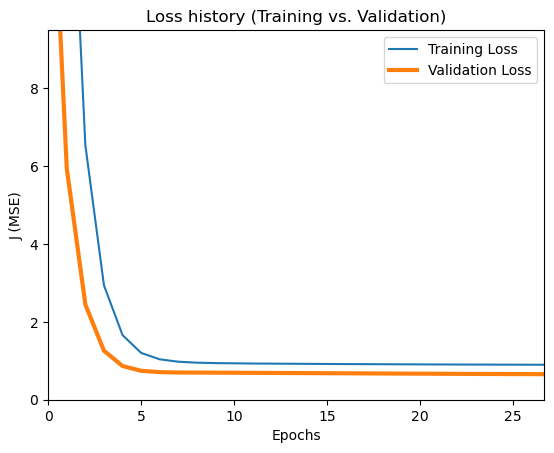

OK


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# model (set to use batch GD)
r = MyLinReg(eta0=0.1, max_iter=1000, tol=1e-6, 
             validation_split=0.2, n_iter_no_change=5, verbose=True)
r.fit(X, y)

%matplotlib inline
fig, ax = plt.subplots()

plt.plot(r.train_loss_history_, label="Training Loss")
plt.plot(r.val_loss_history_, label="Validation Loss", linewidth=3)
ax.legend()

ax.set_title("Loss history (Training vs. Validation)")
ax.set_xlabel("Epochs")
ax.set_ylabel("J (MSE)")

zoom_axis = True
if zoom_axis:
    limits_x = ax.get_xlim()
    limits_y = ax.get_ylim()
    ax.set_ylim([0, limits_y[1]/5])
    ax.set_xlim([0, limits_x[1]/10])
    
plt.show()

print("OK")

### Qd: [OPTIONAL] Using a Polynomial Regressor to Produce an Error-vs-Capacity Graph

Finally, create a polynomial estimator based on your `MyLinReg`, see details of
how to expend a linear regressor to a polynomial fitting in [HOLM] or in

> https://scikit-learn.org/stable/auto_examples/model_selection/plot_underfitting_overfitting.html

that contains most of the code you will need.

With a polynomial regressor, you should be able to reproduce a graph similar to Figure 5.3 from Deep Learning [DL], where you notice that the _x-axis_ is capacity and not _epoch_ as the learning curves you just produced in Qb/c.


In [68]:
assert False "TODO: implement a polynomial-fit pipeline, and create an Error-vs-Capacity plot..

pipeline = Pipeline([
      ("polynomial_features", polynomial_features),
      ("linear_regression",   MyLinReg())
  ])


SyntaxError: EOL while scanning string literal (4094315905.py, line 1)

### Qe Conclusion

Sum it all up in a nice, well-written conclusion.


This exercise was about revising and implementing some very core concepts when training a model. We examined over/under-fitting, how and why it happens. We also looked into how we can prevent this from happening, and thereby how we make sure our model becomes as close to the optimal capacity as possible. This is where techniques such as early stopping comes in, that stops the model from training further, when it is drifing into overfitting territory.

We also talked about learning error vs generalization error, how we measure our models performance on both seen and unseen data, and why the gap between them (the generalization gap) can be a crucial indicator of overfitting.

All these things are present in the figure at the top of the exercise, which gives a visual overview of how these things interact with eachother, and what they mean for our models performance.


| REVISIONS  |                                                                                                                                                     |
| :--------- | :-------------------------------------------------------------------------------------------------------------------------------------------------- |
| 2018-12-19 | CEF, initial.                                                                                                                                       |
| 2018-02-14 | CEF, major update and put in sync with under/overfitting exe.                                                                                       |
| 2018-02-20 | CEF, fixed revision table malformatting.                                                                                                            |
| 2018-02-25 | CEF, minor text updates, and made Qc optional.                                                                                                      |
| 2018-02-25 | CEF, updated code, made more functions.                                                                                                             |
| 2018-03-11 | CEF, corrected RSME to RMSE.                                                                                                                        |
| 2019-10-08 | CEF, updated to ITMAL E19.                                                                                                                          |
| 2020-03-14 | CEF, updated to ITMAL F20.                                                                                                                          |
| 2020-10-15 | CEF, updated to ITMAL E20.                                                                                                                          |
| 2020-11-17 | CEF, added a comment on 90-degree polynomial, made early stopping a pseudo code exe.                                                                |
| 2021-03-22 | CEF, changed crossref from "capacity_under_overfitting.ipynb Qc" to Qa+b in QdExplain the Polynomial RMSE-Capacity Plot.                            |
| 2021-03-23 | CEF, changed 'cv RMSE' legend to 'validation RMSE'.                                                                                                 |
| 2021-10-31 | CEF, updated to ITMAL E21.                                                                                                                          |
| 2022-03-25 | CEF, updated to SWMAL F22.                                                                                                                          |
| 2023-03-16 | CEF, minor update to SWMAL F23.                                                                                                                     |
| 2024-09-25 | CEF, major update, combined generalization_error.ipynb and capacity_under_overfitting.ipynb, removed review parts, added graphs plots for MyLinReg. |
| 2024-10-14 | CEF, minor text updates.                                                                                                                            |
